## 基于pytorch-lighting的GAN模型
首先是准备数据的模型，这里使用data-loader来加载数据，然后使用pytorch-lighting来构建模型，这里使用的是GAN模型，然后使用pytorch-lighting的trainer来训练模型，最后使用模型来生成图片。

In [17]:
# 导入必要的库
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torchvision
from pytorch_lightning.callbacks import Callback
import matplotlib.pyplot as plt

# 第一部分：数据模块
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='home/huilin/project/data', batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # 归一化处理
        ])

    def prepare_data(self):
        # 下载 MNIST 数据
        MNIST(self.data_dir, train=True, download=True, transform=self.transform)
        MNIST(self.data_dir, train=False, download=True, transform=self.transform)

    def setup(self, stage=None):
        # 设置数据集，用于训练和验证
        mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
        self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    def train_dataloader(self):
        # 返回训练集的 DataLoader
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        # 返回验证集的 DataLoader
        return DataLoader(self.mnist_val, batch_size=self.batch_size)



然后是模型的定义，我们定义了generator和discriminator两个模型，然后定义了GAN模型，然后定义了训练的过程。

In [18]:
# 第二部分：模型定义
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


class GAN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.automatic_optimization = False  # 手动优化
        self.generator = Generator()
        self.discriminator = Discriminator()

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        imgs, _ = batch

        # 生成随机噪声
        z = torch.randn(imgs.shape[0], 100, device=self.device)
        # 生成器生成假图片
        generated_imgs = self(z)

        # 判别器判别真实图片和生成图片
        real = torch.ones(imgs.size(0), 1, device=self.device)
        fake = torch.zeros(imgs.size(0), 1, device=self.device)

        # 训练生成器
        self.generator.zero_grad()
        gen_loss = self.adversarial_loss(self.discriminator(generated_imgs), real)
        self.manual_backward(gen_loss)
        self.optimizers()[0].step()

        # 训练判别器
        self.discriminator.zero_grad()
        real_loss = self.adversarial_loss(self.discriminator(imgs), real)
        fake_loss = self.adversarial_loss(self.discriminator(generated_imgs.detach()), fake)
        dis_loss = (real_loss + fake_loss) / 2
        self.manual_backward(dis_loss)
        self.optimizers()[1].step()

        # 日志输出损失
        self.log('gen_loss', gen_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('dis_loss', dis_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def on_epoch_end(self):
        # 在每个 epoch 结束时生成并记录一些图像,并且使用plt打印图像
        z = torch.randn(9, 100, device=self.device)
        sample_images = self.generator(z)
        grid = torchvision.utils.make_grid(sample_images, nrow=3, normalize=True)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)
        print('Epoch:', self.current_epoch)
        plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
        
        

    def configure_optimizers(self):
        opt_gen = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_dis = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        return [opt_gen, opt_dis]


我们需要设置训练器和数据模块，这部分代码将位于

In [19]:
class ImageGenerationCallback(Callback):
    def __init__(self, num_samples=9, figsize=(5, 5)):
        self.num_samples = num_samples
        self.figsize = figsize

    def on_epoch_end(self, trainer, pl_module):
        print('Generating images...')
        z = torch.randn(self.num_samples, 100, device=pl_module.device)
        pl_module.eval()
        with torch.no_grad():
            images = pl_module(z)
        pl_module.train()
        grid = torchvision.utils.make_grid(images, nrow=int(self.num_samples ** 0.5))
        grid = grid.permute(1, 2, 0).cpu().numpy()
        grid = (grid + 1) / 2  # normalize to [0, 1]

        plt.figure(figsize=self.figsize)
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

def train_gan():
    data_module = MNISTDataModule(data_dir='/home/huilin/project/data')
    model = GAN()
    image_callback = ImageGenerationCallback()

    trainer = pl.Trainer(
        max_epochs=50,
        enable_progress_bar=True,
        #gpus=1 if torch.cuda.is_available() else 0,  # 检查是否有 GPU 可用
        logger=TensorBoardLogger('tb_logs', name='GAN'),
        callbacks=[image_callback]  # 添加回调
    )

    trainer.fit(model, datamodule=data_module)


In [20]:
# 执行训练
train_gan()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/huilin/anaconda3/envs/ML/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.5 M 
1 | discriminator | Discriminator | 1.5 M 
------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.786    Total estimated model params size (MB)
/home/huilin/anaconda3/envs/ML/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` 

Training: |          | 0/? [00:00<?, ?it/s]

/home/huilin/anaconda3/envs/ML/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


模型1的评估

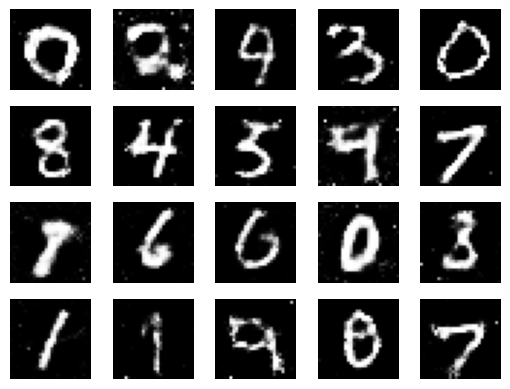

In [ ]:
# 第四部分：生成图像
import matplotlib.pyplot as plt
def generate_images(model_path, num_images=20):
    model = GAN.load_from_checkpoint(model_path)
    model.eval()
    model = model.to('cuda')

    z = torch.randn(num_images, 100, device=model.device)
    images = model(z)
    images = (images + 1) / 2  # 将图像数据重新缩放到 [0, 1]

    for i, image in enumerate(images):
        plt.subplot(4, 5, i+1)
        plt.imshow(image[0].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')


# 生成图像
generate_images('home/huilin/project/model/gan_model.ckpt')